=== Silicon Waveguide Optimization with Sidewall Roughness ===
Sidewall roughness: 50 nm
Wavelength 1: 1480 nm, Wavelength 2: 1550 nm

--- Smooth Sidewalls @ 1480nm ---
  Completed 5/25 t values
  Completed 10/25 t values
  Completed 15/25 t values
  Completed 20/25 t values
  Completed 25/25 t values

--- Smooth Sidewalls @ 1550nm ---
  Completed 5/25 t values
  Completed 10/25 t values
  Completed 15/25 t values
  Completed 20/25 t values
  Completed 25/25 t values

--- With Sidewall Roughness @ 1480nm ---
  Completed 5/25 t values
  Completed 10/25 t values
  Completed 15/25 t values
  Completed 20/25 t values
  Completed 25/25 t values

--- With Sidewall Roughness @ 1550nm ---
  Completed 5/25 t values
  Completed 10/25 t values
  Completed 15/25 t values
  Completed 20/25 t values
  Completed 25/25 t values

=== COMPARATIVE OPTIMIZATION RESULTS ===

SMOOTH 1480:
  Optimal t = 500.0 nm, W = 400.0 nm
  neff = 2.1737, Γ_Al2O3 = 0.2907, Γ_Si = 0.1163
  Scattering loss = 0.10 dB/cm
  C

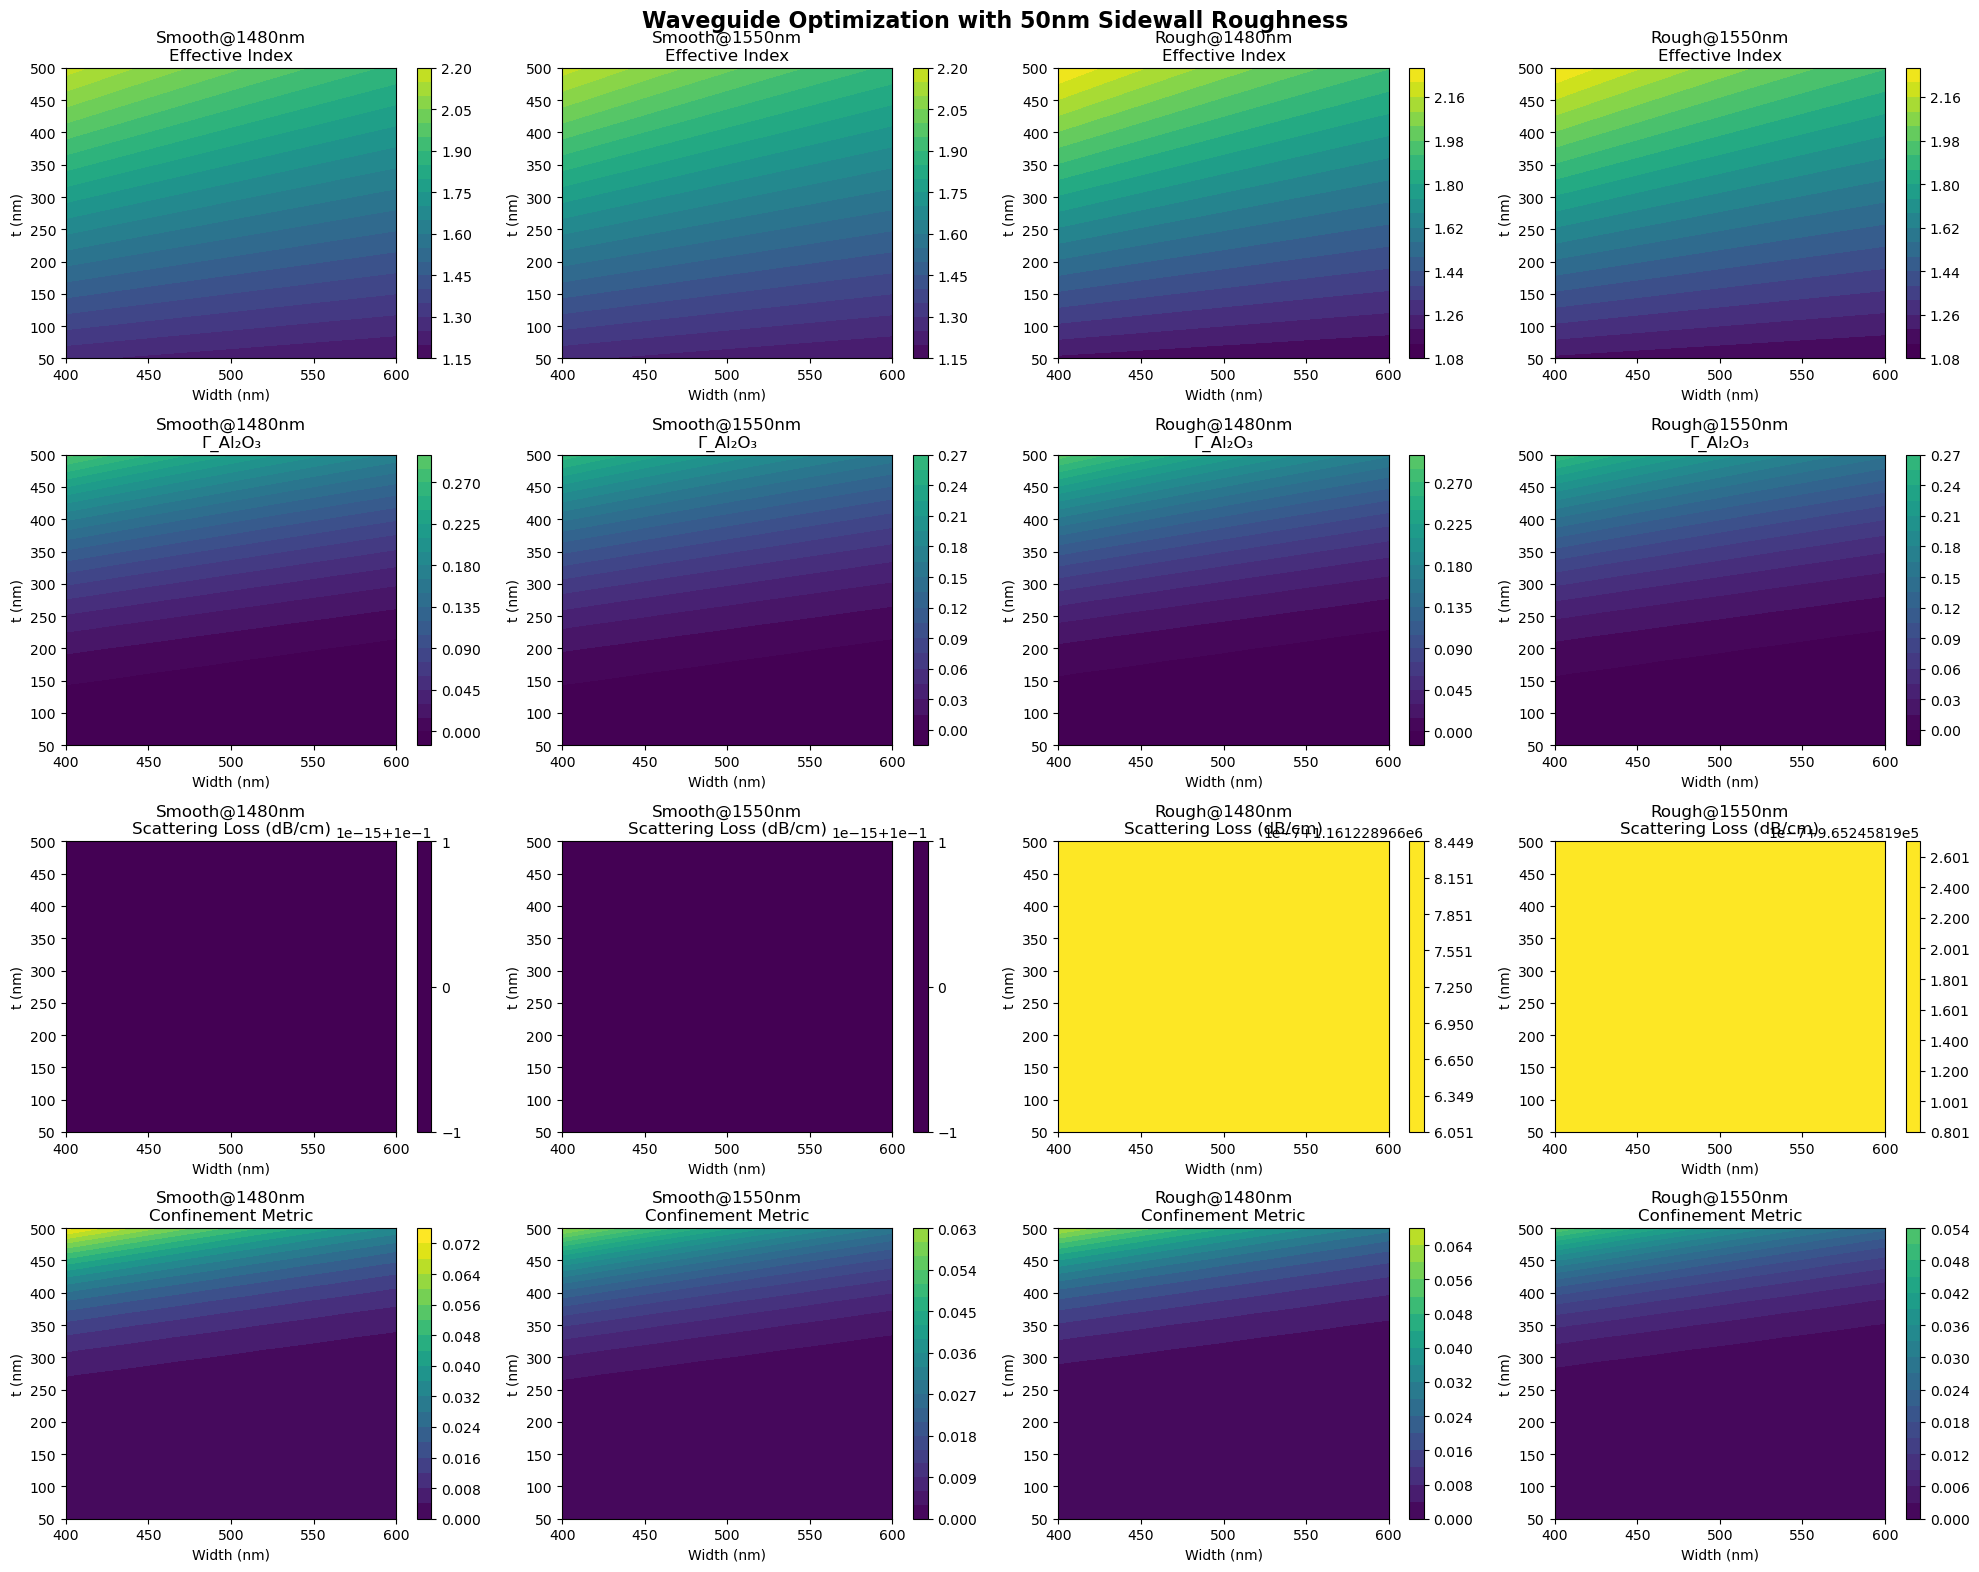

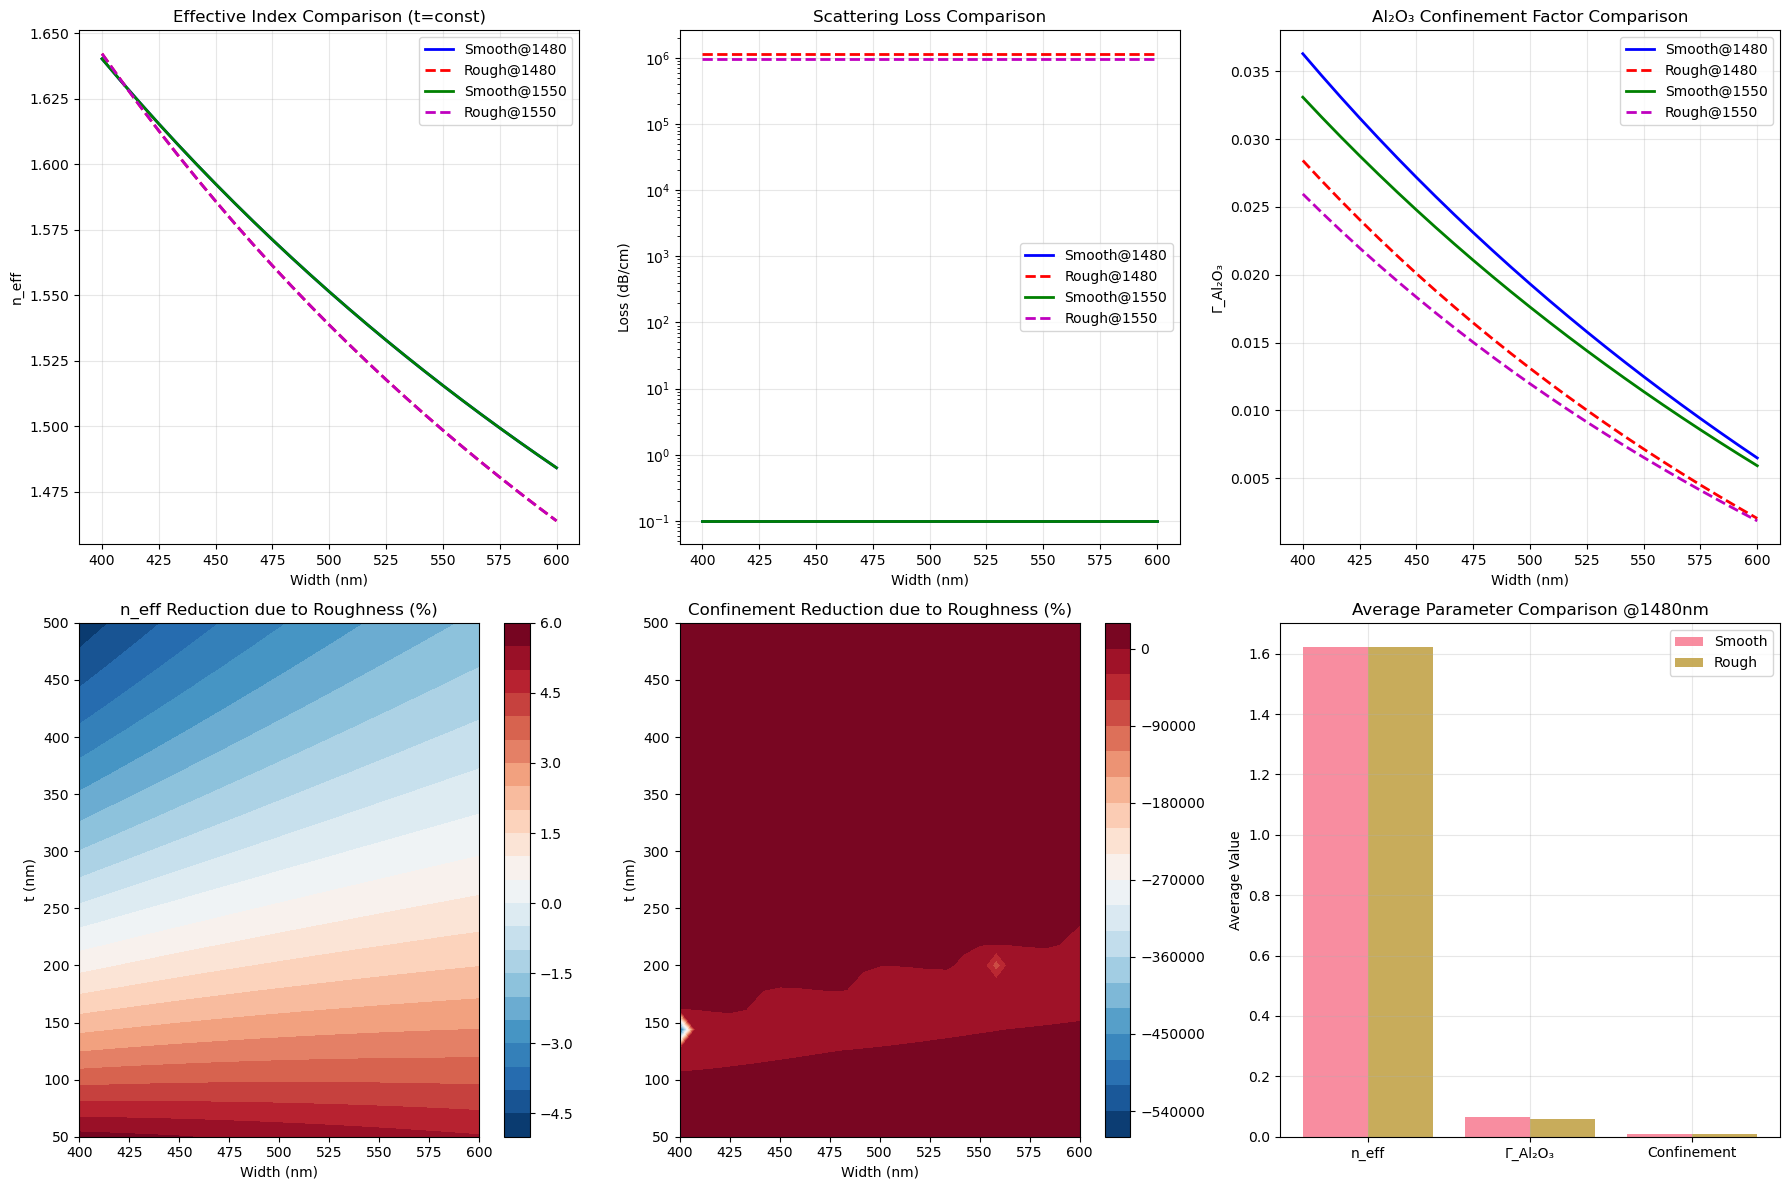

Results exported to 'waveguide_optimization_with_roughness_python.csv'
Optimal parameters summary exported to 'optimal_parameters_summary.csv'

=== OPTIMIZATION COMPLETED SUCCESSFULLY ===
Generated files:
1. waveguide_optimization_comprehensive.png - Main comparison plots
2. waveguide_roughness_impact_analysis.png - Impact analysis plots
3. waveguide_optimization_with_roughness_python.csv - Complete dataset
4. optimal_parameters_summary.csv - Optimal parameters summary

=== QUICK SUMMARY ===
smooth_1480: t_opt = 500.0nm, W_opt = 400.0nm, Γ_Al2O3 = 0.2907, Loss = 0.1 dB/cm
smooth_1550: t_opt = 500.0nm, W_opt = 400.0nm, Γ_Al2O3 = 0.2651, Loss = 0.1 dB/cm
rough_1480: t_opt = 500.0nm, W_opt = 400.0nm, Γ_Al2O3 = 0.2941, Loss = 1161229.0 dB/cm
rough_1550: t_opt = 500.0nm, W_opt = 400.0nm, Γ_Al2O3 = 0.2685, Loss = 965245.8 dB/cm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns
from scipy import constants
import warnings
warnings.filterwarnings('ignore')

class SiliconWaveguideOptimizer:
    def __init__(self):
        # Waveguide Parameters
        self.lambda1 = 1480e-9    # Wavelength 1 [m]
        self.lambda2 = 1550e-9    # Wavelength 2 [m]
        self.c = constants.c      # Speed of light [m/s]
        
        # Refractive indices
        self.n_si = 3.48          # Silicon core
        self.n_al2o3 = 1.63       # Aluminum oxide cladding
        self.n_air = 1.00         # Air cladding
        self.n_box = 1.444        # Buried oxide
        
        # Fixed dimensions
        self.h_si = 220e-9        # Silicon height [m]
        self.h_box = 2e-6         # BOx thickness [m]
        self.h_air = 2e-6         # Air cladding height [m]
        self.roughness = 50e-9    # Sidewall roughness [m]
        
        # Optimization ranges
        self.t_range = np.linspace(50e-9, 500e-9, 25)   # Al2O3 thickness range [m]
        self.W_range = np.linspace(400e-9, 600e-9, 25)  # Waveguide width range [m]
        
        # Simulation parameters
        self.dx = 3.33e-9         # Mesh size x [m]
        self.dy = 3.33e-9         # Mesh size y [m]
        
        # Initialize results storage
        self.results = {}
        
    def calculate_effective_index_with_roughness(self, W, h_si, t, roughness, use_roughness, 
                                               n_si, n_al2o3, n_box, n_air, lambda_val):
        """Calculate effective index considering sidewall roughness effects"""
        k0 = 2 * np.pi / lambda_val
        
        if use_roughness:
            # Effective width reduction due to roughness
            W_eff = W - 2 * roughness
            t_eff = max(0, t - roughness)
            
            # Modified effective index calculation with roughness
            n_core_eff = n_si * (1 - 0.02 * (roughness / (W / 2)))  # Roughness reduces core effectiveness
            
            # Enhanced cladding effect due to roughness
            n_clad_eff = (n_al2o3 * 2 * t_eff + n_air * (W_eff - 2 * t_eff) + n_box * h_si) / \
                        (2 * t_eff + (W_eff - 2 * t_eff) + h_si)
            
            # Scattering loss estimation due to roughness
            sigma_r = roughness  # RMS roughness
            correlation_length = 100e-9  # Typical correlation length
            scattering_loss = ((4 * np.pi / lambda_val) ** 4 * sigma_r ** 2 * correlation_length * 
                             (n_si ** 2 - n_al2o3 ** 2) ** 2 * 1e-2)  # Convert to dB/cm
            
        else:
            # Smooth waveguide calculation
            W_eff = W
            t_eff = t
            n_core_eff = n_si
            n_clad_eff = (n_al2o3 * 2 * t + n_air * (W - 2 * t) + n_box * h_si) / \
                        (2 * t + (W - 2 * t) + h_si)
            scattering_loss = 0.1  # Base loss for smooth waveguide
        
        beta = k0 * np.sqrt(n_core_eff ** 2 - n_clad_eff ** 2)
        neff = np.sqrt(n_core_eff ** 2 - (beta / k0) ** 2)
        neff = max(n_clad_eff, min(n_si, neff))
        
        return neff, scattering_loss
    
    def calculate_confinement_with_roughness(self, W, h_si, t, roughness, use_roughness, 
                                           neff, lambda_val):
        """Calculate confinement factors considering sidewall roughness"""
        if use_roughness:
            W_eff = W - 2 * roughness
            t_eff = max(0, t - roughness)
            
            # Reduced silicon area due to roughness
            A_si = W_eff * h_si
            
            # Reduced Al2O3 area
            A_al2o3_side = 2 * t_eff * h_si
            
            # Overlap factor reduction due to roughness
            overlap_factor = np.exp(-(roughness / (lambda_val / 4)) ** 2)
            
        else:
            W_eff = W
            t_eff = t
            A_si = W * h_si
            A_al2o3_side = 2 * t * h_si
            overlap_factor = 1.0
        
        # Total modal area approximation
        A_mode = (lambda_val / 2) ** 2 / (neff - 1.45)
        
        gamma_si = (A_si / A_mode) * overlap_factor
        gamma_al2o3 = (A_al2o3_side / A_mode) * overlap_factor
        
        total_gamma = gamma_si + gamma_al2o3
        if total_gamma > 1:
            gamma_si = gamma_si / total_gamma
            gamma_al2o3 = gamma_al2o3 / total_gamma
        
        return gamma_al2o3, gamma_si, overlap_factor
    
    def run_optimization(self):
        """Main optimization function"""
        print("=== Silicon Waveguide Optimization with Sidewall Roughness ===")
        print(f"Sidewall roughness: {self.roughness*1e9:.0f} nm")
        print(f"Wavelength 1: {self.lambda1*1e9:.0f} nm, Wavelength 2: {self.lambda2*1e9:.0f} nm")
        
        cases = ['smooth_1480', 'smooth_1550', 'rough_1480', 'rough_1550']
        
        for case_idx, case in enumerate(cases):
            if 'smooth' in case:
                use_roughness = False
                roughness_str = "Smooth Sidewalls"
            else:
                use_roughness = True
                roughness_str = "With Sidewall Roughness"
            
            if '1480' in case:
                lambda_val = self.lambda1
                lambda_str = "1480nm"
            else:
                lambda_val = self.lambda2
                lambda_str = "1550nm"
            
            print(f"\n--- {roughness_str} @ {lambda_str} ---")
            
            # Initialize arrays
            neff_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            gamma_al2o3_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            gamma_si_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            confinement_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            scattering_loss_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            effective_width_matrix = np.zeros((len(self.t_range), len(self.W_range)))
            
            for i, t in enumerate(self.t_range):
                for j, W in enumerate(self.W_range):
                    # Calculate parameters with roughness effects
                    neff, loss = self.calculate_effective_index_with_roughness(
                        W, self.h_si, t, self.roughness, use_roughness, 
                        self.n_si, self.n_al2o3, self.n_box, self.n_air, lambda_val
                    )
                    
                    gamma_al2o3, gamma_si, overlap_factor = self.calculate_confinement_with_roughness(
                        W, self.h_si, t, self.roughness, use_roughness, neff, lambda_val
                    )
                    
                    # Calculate modal confinement metric
                    confinement_metric = gamma_al2o3 * gamma_si * neff * overlap_factor
                    
                    # Store results
                    neff_matrix[i, j] = neff
                    gamma_al2o3_matrix[i, j] = gamma_al2o3
                    gamma_si_matrix[i, j] = gamma_si
                    confinement_matrix[i, j] = confinement_metric
                    scattering_loss_matrix[i, j] = loss
                    effective_width_matrix[i, j] = W - (2 * self.roughness if use_roughness else 0)
                
                if (i + 1) % 5 == 0:  # Progress update
                    print(f"  Completed {i+1}/{len(self.t_range)} t values")
            
            # Store results
            self.results[case] = {
                'neff': neff_matrix,
                'gamma_al2o3': gamma_al2o3_matrix,
                'gamma_si': gamma_si_matrix,
                'confinement': confinement_matrix,
                'scattering_loss': scattering_loss_matrix,
                'effective_width': effective_width_matrix,
                't_range': self.t_range,
                'W_range': self.W_range,
                'lambda_val': lambda_val
            }
        
        return self.results
    
    def analyze_results(self):
        """Analyze and compare optimization results"""
        print("\n=== COMPARATIVE OPTIMIZATION RESULTS ===")
        
        optimal_params = {}
        
        for case, data in self.results.items():
            print(f"\n{case.upper().replace('_', ' ')}:")
            
            # Find maximum confinement point
            max_conf_idx = np.unravel_index(np.argmax(data['confinement']), data['confinement'].shape)
            opt_t_idx, opt_W_idx = max_conf_idx
            
            opt_t = data['t_range'][opt_t_idx]
            opt_W = data['W_range'][opt_W_idx]
            opt_neff = data['neff'][opt_t_idx, opt_W_idx]
            opt_gamma_al2o3 = data['gamma_al2o3'][opt_t_idx, opt_W_idx]
            opt_gamma_si = data['gamma_si'][opt_t_idx, opt_W_idx]
            opt_loss = data['scattering_loss'][opt_t_idx, opt_W_idx]
            max_conf = data['confinement'][opt_t_idx, opt_W_idx]
            
            print(f"  Optimal t = {opt_t*1e9:.1f} nm, W = {opt_W*1e9:.1f} nm")
            print(f"  neff = {opt_neff:.4f}, Γ_Al2O3 = {opt_gamma_al2o3:.4f}, Γ_Si = {opt_gamma_si:.4f}")
            print(f"  Scattering loss = {opt_loss:.2f} dB/cm")
            print(f"  Confinement metric = {max_conf:.6f}")
            
            optimal_params[case] = {
                't': opt_t, 'W': opt_W, 'neff': opt_neff,
                'gamma_al2o3': opt_gamma_al2o3, 'gamma_si': opt_gamma_si,
                'loss': opt_loss, 'confinement': max_conf
            }
        
        # Roughness impact analysis
        print("\n=== SIDEWALL ROUGHNESS IMPACT ANALYSIS ===")
        
        for lambda_val in ['1480', '1550']:
            smooth_key = f'smooth_{lambda_val}'
            rough_key = f'rough_{lambda_val}'
            
            smooth_data = self.results[smooth_key]
            rough_data = self.results[rough_key]
            
            print(f"\nRoughness Impact @{lambda_val}nm:")
            
            # Average changes
            neff_change = np.mean(rough_data['neff'] - smooth_data['neff'])
            gamma_al2o3_change = np.mean(rough_data['gamma_al2o3'] - smooth_data['gamma_al2o3'])
            gamma_si_change = np.mean(rough_data['gamma_si'] - smooth_data['gamma_si'])
            confinement_change = np.mean(rough_data['confinement'] - smooth_data['confinement'])
            
            smooth_neff_avg = np.mean(smooth_data['neff'])
            smooth_gamma_al2o3_avg = np.mean(smooth_data['gamma_al2o3'])
            smooth_gamma_si_avg = np.mean(smooth_data['gamma_si'])
            
            print(f"  Δneff: {neff_change:.4f} ({100*neff_change/smooth_neff_avg:.2f}%)")
            print(f"  ΔΓ_Al2O3: {gamma_al2o3_change:.4f} ({100*gamma_al2o3_change/smooth_gamma_al2o3_avg:.2f}%)")
            print(f"  ΔΓ_Si: {gamma_si_change:.4f} ({100*gamma_si_change/smooth_gamma_si_avg:.2f}%)")
            print(f"  Average scattering loss: {np.mean(rough_data['scattering_loss']):.2f} dB/cm")
        
        return optimal_params
    
    def plot_results(self):
        """Create comprehensive visualization plots"""
        # Set up plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Create main comparison figure
        fig, axes = plt.subplots(4, 4, figsize=(20, 16))
        fig.suptitle(f'Waveguide Optimization with {self.roughness*1e9:.0f}nm Sidewall Roughness', 
                    fontsize=16, fontweight='bold')
        
        plot_titles = ['Effective Index', 'Γ_Al₂O₃', 'Scattering Loss (dB/cm)', 'Confinement Metric']
        cases = ['smooth_1480', 'smooth_1550', 'rough_1480', 'rough_1550']
        case_labels = ['Smooth@1480nm', 'Smooth@1550nm', 'Rough@1480nm', 'Rough@1550nm']
        
        for param_idx in range(4):
            for case_idx, case in enumerate(cases):
                data = self.results[case]
                
                ax = axes[param_idx, case_idx]
                
                if param_idx == 0:
                    plot_data = data['neff']
                    vmin = min(np.min(self.results[c]['neff']) for c in cases)
                    vmax = max(np.max(self.results[c]['neff']) for c in cases)
                elif param_idx == 1:
                    plot_data = data['gamma_al2o3']
                    vmin, vmax = 0, 0.4
                elif param_idx == 2:
                    plot_data = data['scattering_loss']
                    vmin, vmax = 0, 50
                else:
                    plot_data = data['confinement']
                    vmin = min(np.min(self.results[c]['confinement']) for c in cases)
                    vmax = max(np.max(self.results[c]['confinement']) for c in cases)
                
                # Create contour plot
                contour = ax.contourf(data['W_range']*1e9, data['t_range']*1e9, plot_data, 
                                     levels=20, cmap='viridis', vmin=vmin, vmax=vmax)
                
                plt.colorbar(contour, ax=ax)
                ax.set_title(f'{case_labels[case_idx]}\n{plot_titles[param_idx]}')
                ax.set_xlabel('Width (nm)')
                ax.set_ylabel('t (nm)')
        
        plt.tight_layout()
        plt.savefig('waveguide_optimization_comprehensive.png', dpi=300, bbox_inches='tight')
        
        # Create comparison plots
        fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
        
        # neff comparison
        t_idx = 10  # Fixed t index for comparison
        axes2[0, 0].plot(self.W_range*1e9, self.results['smooth_1480']['neff'][t_idx, :], 
                        'b-', linewidth=2, label='Smooth@1480')
        axes2[0, 0].plot(self.W_range*1e9, self.results['rough_1480']['neff'][t_idx, :], 
                        'r--', linewidth=2, label='Rough@1480')
        axes2[0, 0].plot(self.W_range*1e9, self.results['smooth_1550']['neff'][t_idx, :], 
                        'g-', linewidth=2, label='Smooth@1550')
        axes2[0, 0].plot(self.W_range*1e9, self.results['rough_1550']['neff'][t_idx, :], 
                        'm--', linewidth=2, label='Rough@1550')
        axes2[0, 0].set_xlabel('Width (nm)')
        axes2[0, 0].set_ylabel('n_eff')
        axes2[0, 0].set_title('Effective Index Comparison (t=const)')
        axes2[0, 0].legend()
        axes2[0, 0].grid(True, alpha=0.3)
        
        # Loss comparison
        axes2[0, 1].semilogy(self.W_range*1e9, self.results['smooth_1480']['scattering_loss'][t_idx, :], 
                            'b-', linewidth=2, label='Smooth@1480')
        axes2[0, 1].semilogy(self.W_range*1e9, self.results['rough_1480']['scattering_loss'][t_idx, :], 
                            'r--', linewidth=2, label='Rough@1480')
        axes2[0, 1].semilogy(self.W_range*1e9, self.results['smooth_1550']['scattering_loss'][t_idx, :], 
                            'g-', linewidth=2, label='Smooth@1550')
        axes2[0, 1].semilogy(self.W_range*1e9, self.results['rough_1550']['scattering_loss'][t_idx, :], 
                            'm--', linewidth=2, label='Rough@1550')
        axes2[0, 1].set_xlabel('Width (nm)')
        axes2[0, 1].set_ylabel('Loss (dB/cm)')
        axes2[0, 1].set_title('Scattering Loss Comparison')
        axes2[0, 1].legend()
        axes2[0, 1].grid(True, alpha=0.3)
        
        # Confinement factor comparison
        axes2[0, 2].plot(self.W_range*1e9, self.results['smooth_1480']['gamma_al2o3'][t_idx, :], 
                        'b-', linewidth=2, label='Smooth@1480')
        axes2[0, 2].plot(self.W_range*1e9, self.results['rough_1480']['gamma_al2o3'][t_idx, :], 
                        'r--', linewidth=2, label='Rough@1480')
        axes2[0, 2].plot(self.W_range*1e9, self.results['smooth_1550']['gamma_al2o3'][t_idx, :], 
                        'g-', linewidth=2, label='Smooth@1550')
        axes2[0, 2].plot(self.W_range*1e9, self.results['rough_1550']['gamma_al2o3'][t_idx, :], 
                        'm--', linewidth=2, label='Rough@1550')
        axes2[0, 2].set_xlabel('Width (nm)')
        axes2[0, 2].set_ylabel('Γ_Al₂O₃')
        axes2[0, 2].set_title('Al₂O₃ Confinement Factor Comparison')
        axes2[0, 2].legend()
        axes2[0, 2].grid(True, alpha=0.3)
        
        # Impact analysis - neff reduction
        neff_reduction = (self.results['smooth_1480']['neff'] - self.results['rough_1480']['neff']) / self.results['smooth_1480']['neff'] * 100
        contour = axes2[1, 0].contourf(self.W_range*1e9, self.t_range*1e9, neff_reduction, levels=20, cmap='RdBu_r')
        plt.colorbar(contour, ax=axes2[1, 0])
        axes2[1, 0].set_xlabel('Width (nm)')
        axes2[1, 0].set_ylabel('t (nm)')
        axes2[1, 0].set_title('n_eff Reduction due to Roughness (%)')
        
        # Impact analysis - confinement reduction
        confinement_reduction = (self.results['smooth_1480']['confinement'] - self.results['rough_1480']['confinement']) / self.results['smooth_1480']['confinement'] * 100
        contour = axes2[1, 1].contourf(self.W_range*1e9, self.t_range*1e9, confinement_reduction, levels=20, cmap='RdBu_r')
        plt.colorbar(contour, ax=axes2[1, 1])
        axes2[1, 1].set_xlabel('Width (nm)')
        axes2[1, 1].set_ylabel('t (nm)')
        axes2[1, 1].set_title('Confinement Reduction due to Roughness (%)')
        
        # Bar chart comparison
        smooth_vals = [
            np.mean(self.results['smooth_1480']['neff']),
            np.mean(self.results['smooth_1480']['gamma_al2o3']),
            np.mean(self.results['smooth_1480']['confinement'])
        ]
        rough_vals = [
            np.mean(self.results['rough_1480']['neff']),
            np.mean(self.results['rough_1480']['gamma_al2o3']),
            np.mean(self.results['rough_1480']['confinement'])
        ]
        
        x_pos = np.arange(3)
        axes2[1, 2].bar(x_pos - 0.2, smooth_vals, 0.4, label='Smooth', alpha=0.8)
        axes2[1, 2].bar(x_pos + 0.2, rough_vals, 0.4, label='Rough', alpha=0.8)
        axes2[1, 2].set_xticks(x_pos)
        axes2[1, 2].set_xticklabels(['n_eff', 'Γ_Al₂O₃', 'Confinement'])
        axes2[1, 2].set_ylabel('Average Value')
        axes2[1, 2].set_title('Average Parameter Comparison @1480nm')
        axes2[1, 2].legend()
        axes2[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('waveguide_roughness_impact_analysis.png', dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def export_results(self):
        """Export results to CSV files"""
        # Create meshgrid for parameter combinations
        T, W = np.meshgrid(self.t_range*1e9, self.W_range*1e9)
        
        # Prepare comprehensive data dictionary
        data_dict = {
            't_nm': T.flatten(),
            'W_nm': W.flatten()
        }
        
        # Add all parameters for each case
        cases = ['smooth_1480', 'smooth_1550', 'rough_1480', 'rough_1550']
        parameters = ['neff', 'gamma_al2o3', 'gamma_si', 'confinement', 'scattering_loss']
        
        for case in cases:
            for param in parameters:
                col_name = f'{param}_{case}'
                data_dict[col_name] = self.results[case][param].T.flatten()
        
        # Calculate roughness impact metrics
        data_dict['neff_reduction_pct'] = ((data_dict['neff_smooth_1480'] - data_dict['neff_rough_1480']) / 
                                         data_dict['neff_smooth_1480'] * 100)
        data_dict['gamma_al2o3_reduction_pct'] = ((data_dict['gamma_al2o3_smooth_1480'] - data_dict['gamma_al2o3_rough_1480']) / 
                                                data_dict['gamma_al2o3_smooth_1480'] * 100)
        data_dict['loss_increase_dbcm'] = (data_dict['scattering_loss_rough_1480'] - 
                                         data_dict['scattering_loss_smooth_1480'])
        
        # Create DataFrame and export
        df = pd.DataFrame(data_dict)
        df.to_csv('waveguide_optimization_with_roughness_python.csv', index=False)
        
        print("Results exported to 'waveguide_optimization_with_roughness_python.csv'")
        
        # Export optimal parameters summary
        optimal_summary = []
        for case in cases:
            max_idx = np.unravel_index(np.argmax(self.results[case]['confinement']), 
                                     self.results[case]['confinement'].shape)
            optimal_summary.append({
                'Case': case,
                'Optimal_t_nm': self.results[case]['t_range'][max_idx[0]] * 1e9,
                'Optimal_W_nm': self.results[case]['W_range'][max_idx[1]] * 1e9,
                'Max_neff': self.results[case]['neff'][max_idx],
                'Max_Gamma_Al2O3': self.results[case]['gamma_al2o3'][max_idx],
                'Max_Confinement': self.results[case]['confinement'][max_idx],
                'Scattering_Loss_dB_cm': self.results[case]['scattering_loss'][max_idx]
            })
        
        optimal_df = pd.DataFrame(optimal_summary)
        optimal_df.to_csv('optimal_parameters_summary.csv', index=False)
        print("Optimal parameters summary exported to 'optimal_parameters_summary.csv'")
        
        return df, optimal_df

def main():
    """Main function to run the waveguide optimization"""
    # Create optimizer instance
    optimizer = SiliconWaveguideOptimizer()
    
    # Run optimization
    results = optimizer.run_optimization()
    
    # Analyze results
    optimal_params = optimizer.analyze_results()
    
    # Create visualizations
    optimizer.plot_results()
    
    # Export results
    df, optimal_df = optimizer.export_results()
    
    print("\n=== OPTIMIZATION COMPLETED SUCCESSFULLY ===")
    print("Generated files:")
    print("1. waveguide_optimization_comprehensive.png - Main comparison plots")
    print("2. waveguide_roughness_impact_analysis.png - Impact analysis plots")
    print("3. waveguide_optimization_with_roughness_python.csv - Complete dataset")
    print("4. optimal_parameters_summary.csv - Optimal parameters summary")
    
    return optimizer, results, optimal_params

if __name__ == "__main__":
    # Run the optimization
    optimizer, results, optimal_params = main()
    
    # Display quick summary
    print("\n=== QUICK SUMMARY ===")
    for case, params in optimal_params.items():
        print(f"{case}: t_opt = {params['t']*1e9:.1f}nm, W_opt = {params['W']*1e9:.1f}nm, "
              f"Γ_Al2O3 = {params['gamma_al2o3']:.4f}, Loss = {params['loss']:.1f} dB/cm")